In [25]:
#Part 3: Twitter Application Development

#Team Members:
#Anant Gupta
#Jayant Solanki

In [2]:
library(maptools)
library(twitteR)
library(ggplot2)
library('ggmap')
library(maps)
library(mapdata)

Warning message:
"package 'maptools' was built under R version 3.4.3"Loading required package: sp
Warning message:
"package 'sp' was built under R version 3.4.3"Checking rgeos availability: FALSE
 	Note: when rgeos is not available, polygon geometry 	computations in maptools depend on gpclib,
 	which has a restricted licence. It is disabled by default;
 	to enable gpclib, type gpclibPermit()
Warning message:
"package 'twitteR' was built under R version 3.4.3"Warning message:
"package 'ggplot2' was built under R version 3.4.3"Warning message:
"package 'ggmap' was built under R version 3.4.3"Warning message:
"package 'mapdata' was built under R version 3.4.3"

In [3]:
#Here we are setting up the twitter api for use
api_key <- "M3uDdeL5NzbjfdBGVtL5r9PZu" 
api_secret <- "yF3yQnM05yuZgVSDKsaMWePs3M93f7XQh6PQHOQazyytvlMzSM" 
token <- "417187736-o3vz5smd7Y50QIfPxVpWdKTTA645OwRRDJhfRZBU" 
token_secret <- "x7IbwZMcIgl29ee5uYbaHfOf5VUQh2e0rkbNFasTjk5Mq"
setup_twitter_oauth(api_key, api_secret, token, token_secret)

[1] "Using direct authentication"


In [14]:
# Here we are collecting the tweet having any of these keywords "flu OR #flu OR influenza OR #Influenza OR fever OR #fluseason"
# Geocode argument is used by passing the longitude and latitude values for the centre of the US and the radius value as 3881 miles to cover the entire reagon of US
tweets <- searchTwitter("flu OR #flu OR influenza OR #Influenza OR fever OR #fluseason", n = 1000, geocode = '42.877742,-97.380979,3881mi',since="2018-02-03", lang = "en")
tweets_df <-twListToDF(tweets)
# We are saving the tweets collected in a csv file
#write.csv(tweets_df, "C:/Users/anu21/Anant/Google Drive/MASTERS/Courses/Spring 2018/DIC/Final Twitter Data/RawTweets.csv")

In [12]:
# Here we are getting the finding the unique screen names and then looking up for the corresponding profile using lookupUsers function
# After geting the users we are cleaning the result to remove any values that might create discrepancy
# Finally we are saving the locations in a csv file
screenNames <- unique(tweets_df$screenName)
screenNames <- unique(tweets_df$screenName)
userDF <- twListToDF(lookupUsers(screenNames))
screenNamedf <- data.frame(userDF$screenName,userDF$location)
colnames(screenNamedf) <- c("ScreenName","Location")
screenNamedf <- na.omit(screenNamedf)
screenNamedf <- screenNamedf[length(screenNamedf$Location) != 0,]
screenNamedf <- screenNamedf[screenNamedf$Location != " ",]
screenNamedf <- screenNamedf[screenNamedf$Location != "",]
screenNamedf <- screenNamedf[screenNamedf$Location != "   ",]
#write.csv(screenNamedf, paste("C:/Users/anu21/Anant/Google Drive/MASTERS/Courses/Spring 2018/DIC/Final Twitter Data/FinalData.csv"))

In [17]:
#Here we are loading the csv file saved earlier which has the Location details and use the geocode function to get the latitude
# and longitude values for each tweets. Here we have loaded only few location to save time.
# Finally all the Long and Lat values were saved in a csv file and the process was repeated, since we can get only 2.5k geo-
#location per day
path <- "C:/Users/anu21/Anant/Google Drive/MASTERS/Courses/Spring 2018/DIC/Final Twitter Data/FinalData.csv"
plot <- read.csv(file=path,sep=",")
geocode <- geocode(as.character(plot$Location[1:15]))
plotPoints <- data.frame(geocode)
plotPoints <- na.omit(plotPoints)
#write.csv(plotPoints, "C:/Users/anu21/Anant/Google Drive/MASTERS/Courses/Spring 2018/DIC/Final Twitter Data/Lon_Lat.csv")

Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=ohio--chicago--california&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Indianapolis&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=United%20States&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=New%20Hampshire%20/%20Vermont&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=California&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Circle%20Pines,%20MN%20USA%20%3Ced%3E%3CU+00A0%3E%3CU+00BC%3E%3Ced%3E%3CU+00B7%3E%3CU+00BA%3E%3Ced%3E%3CU+00A0%3E%3CU+00BC%3E%3Ced%3E%3CU+00B7%3E%3CU+00B8%3E&sensor=false
Warning message:
"geocode failed with status ZERO_RESULTS, location = "Circle Pines, MN USA <ed><U+00A0><U+00BC><ed><U+00B7><U+00BA><ed><U+00A0><U+00BC><ed><U+00B7><U+00B8>""Information fr

In [22]:
# Here we are loading the csv file which contains the longitude and latitude values of all the tweets
# And then we are using the latlong2state function to get the state name from the lon-lat values
path <- "C:/Users/anu21/Anant/Google Drive/MASTERS/Courses/Spring 2018/DIC/Final Twitter Data/Lon_Lat.csv"
plot <- read.csv(file=path,sep=",")
plot <- data.frame(plot$lon,plot$lat)

latlong2state <- function(pointsDF) {
  # Prepare SpatialPolygons object with one SpatialPolygon
  # per state (plus DC, minus HI & AK)
  states <- map('state', fill=TRUE, col="transparent", plot=FALSE)
  IDs <- sapply(strsplit(states$names, ":"), function(x) x[1])
  states_sp <- map2SpatialPolygons(states, IDs=IDs,
                                   proj4string=CRS("+proj=longlat +datum=wgs84"))
  
  # Convert pointsDF to a SpatialPoints object 
  pointsSP <- SpatialPoints(pointsDF, 
                            proj4string=CRS("+proj=longlat +datum=wgs84"))
  
  # Use 'over' to get _indices_ of the Polygons object containing each point 
  indices <- over(pointsSP, states_sp)
  
  # Return the state names of the Polygons object containing each point
  stateNames <- sapply(states_sp@polygons, function(x) x@ID)
  stateNames[indices]
}
                       
state_name <- latlong2state(plot)
state_name <- na.omit(state_name)

In [19]:
# Here we use the statenames data and then create a table which shows the frequency of tweets in each state
state <- table(state_name)
statedata <- as.data.frame(state)
statedata

state_name,Freq
alabama,21
arizona,11
arkansas,12
california,73
colorado,29
connecticut,23
delaware,5
district of columbia,36
florida,75
georgia,69


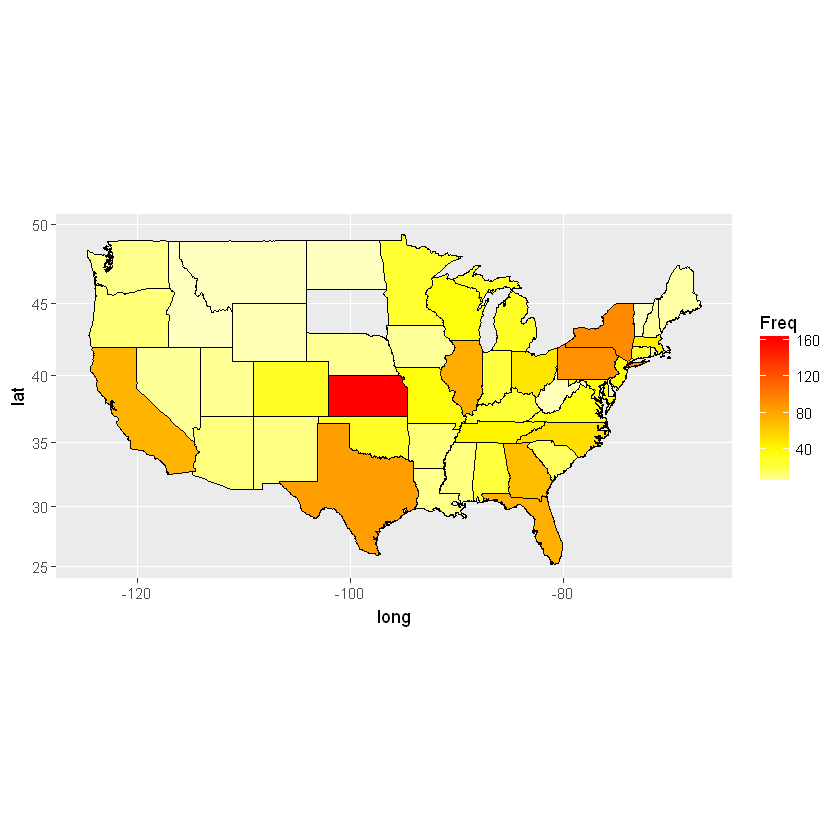

In [23]:
# Finally we have all the count of tweets state-wise in statedata. We use this data to plot the map using ggplot and other map functions
statedata$region <- tolower(statedata$state_name)
states <- map_data("state")
map.df <- merge(states,statedata, by="region", all.statedata=T)
map.df <- map.df[order(map.df$order),]
ggplot(map.df, aes(x=long,y=lat,group=group))+
  geom_polygon(aes(fill=Freq))+
  geom_path()+ 
  scale_fill_gradientn(colours=rev(heat.colors(10)),na.value="grey90")+
  coord_map()